In [1]:
# Import necessary libraries
import random
import time
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import statsmodels.api as sm
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Activation
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers

import ssl
ssl._create_default_https_context = ssl._create_stdlib_context


2024-10-18 08:59:33.236600: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:

# Setting a seed for reproducibility
np.random.seed(0)
tf.random.set_seed(0)
random.seed(0)


## Preprocessing

#### Step 1: Download the Data

In [3]:
# Retrieve the data
def load_data(fred_path: str):
    """
    Function to load data either from a local file or from FRED if the file doesn't exist locally.

    Args:
    fred_path (str): URL to fetch the dataset from FRED.

    Returns:
    DataFrame: Loaded dataset.
    """
    
    print("Be patient: loading from FRED (2 minutes)")
    df = pd.read_csv(fred_path, nrows=729)
    print("Done")

    tcodes = df.iloc[0, 1:]  # data tickers
    df.drop(0, inplace=True) # Drop unnecessary row

    # Set index to date and format it as datetime
    df = df.set_index("sasdate", drop=True)
    df.index = pd.to_datetime(df.index, format='%m/%d/%Y')

    return df, tcodes

#### Step 2: Transform the Data

In [4]:
def transxf(x, tcode):
    """
    DESCRIPTION:
    This function transforms a single series (in a column vector)
    as specified by a given transformation code.

    INPUT:
        x      : Series (in a column vector) to be transformed
        tcode  : Transformation code (1-7)

    OUTPUT:
        result : Transformed series (as a column vector)

    """
    # Number of observations (including missing values)
    n = x.size

    # Value close to zero
    small = 1e-6

    # Allocate output variables
    y = np.nan * np.ones(n)
    y1 = np.nan * np.ones(n)

    # Initialize result to ensure it's always defined
    result = np.nan * np.ones(n)

    # Transformation logic
    if tcode == 1:  # No transformation: x(t)
        result = x

    elif tcode == 2:  # First difference: x(t) - x(t-1)
        y[1:] = x[1:] - x[:-1]
        result = y

    elif tcode == 3:  # Second difference: (x(t) - x(t-1)) - (x(t-1) - x(t-2))
        y[2:] = x[2:] - 2 * x[1:-1] + x[:-2]
        result = y

    elif tcode == 4:  # Natural log: ln(x)
        if np.min(x) < small:
            result = np.nan
        else:
            result = np.log(x)

    elif tcode == 5:  # First difference of natural log: ln(x) - ln(x-1)
        if np.min(x[pd.notnull(x)]) > small:
            log_x = np.log(x)
            y[1:] = log_x[1:] - log_x[:-1]
            result = y

    elif tcode == 6:  # Second difference of natural log
        if np.min(x[pd.notnull(x)]) > small:
            log_x = np.log(x)
            y[2:] = log_x[2:] - 2 * log_x[1:-1] + log_x[:-2]
            result = y

    elif tcode == 7:  # First difference of percent change
        y1[1:] = (x[1:] - x[:-1]) / x[:-1]
        y[2:] = y1[2:] - y1[1:-1]
        result = y

    return result

#### Step 3: Define the Target Variable 

In [5]:
# Define the target variable (S&P 500 Returns)
def preprocess_data(df):
    """
    Preprocess the data by creating the target variable (S&P 500 log returns) and removing NaNs.

    Args:
    df (DataFrame): Data containing S&P 500 returns.

    Returns:
    DataFrame: Processed data with target variable.
    """
    df['Target'] = df['S&P 500'].shift(periods=-1)
    df.drop(['S&P 500', 'VIXCLSx'], axis=1, inplace=True)
    df = df.apply(lambda x: x.fillna(x.rolling(window=6, min_periods=1).mean()))
    df.dropna(inplace=True)

    return df

## Defining the Models

#### Defining the NN model

In [6]:
# Create the early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=5,          # Stop after 5 epochs with no improvement
    restore_best_weights=True  # Restore model weights from the best epoch
)


class MCDropout(tf.keras.layers.Dropout):
    def call(self, inputs):
        return super().call(inputs, training=True)


# Define the neural network model
def build_neural_network(input_dim, l2_reg, dropout_rate):
    """
    Function to build a neural network model for regression tasks.

    Args:
    input_dim (int): Number of features (input dimension).

    Returns:
    model: Compiled neural network model.
    """
    inputs = Input(shape=(input_dim,))
    x = MCDropout(dropout_rate)(inputs)
    x = Dense(8, activation='relu', kernel_regularizer=regularizers.l2(l2_reg))(x)
    x = MCDropout(dropout_rate)(x)
    x = Dense(4, activation='relu', kernel_regularizer=regularizers.l2(l2_reg))(x)
    x = MCDropout(dropout_rate)(x)
    x = Dense(2, activation='relu', kernel_regularizer=regularizers.l2(l2_reg))(x)
    x = MCDropout(dropout_rate)(x)
    outputs = Dense(1, activation='linear')(x)
    model = Model(inputs=inputs, outputs=outputs)

    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='mean_squared_error')

    return model

## Estimating the Models

In [7]:
# Estimating the Forecasting Models
def train_models(train_data_scaled, train_pca, input_dim):
    """
    Train multiple forecasting models (OLS, LASSO, Decision Tree, Random Forest, and Neural Network).

    Args:
    train_data_scaled (DataFrame): Scaled training data.
    train_pca (DataFrame): Training data after applying PCA.
    input_dim (int): Input dimension for the neural network model.

    Returns:
    Dict: Trained models.
    """
    models = {
        'ols': LinearRegression(fit_intercept=True).fit(train_data_scaled.drop("Target", axis=1),
                                                        train_data_scaled["Target"]),
        'ols_pca': LinearRegression(fit_intercept=True).fit(train_pca, train_data_scaled["Target"]),
        'lasso': Lasso(alpha=0.005, fit_intercept=True).fit(train_data_scaled.drop("Target", axis=1),
                                                            train_data_scaled['Target']),
        'd_tree': DecisionTreeRegressor(max_depth=10).fit(train_data_scaled.drop("Target", axis=1),
                                                            train_data_scaled["Target"]),
        'r_forest': RandomForestRegressor(max_depth=10, random_state=0, n_estimators=20).fit(
            train_data_scaled.drop("Target", axis=1), train_data_scaled["Target"])
    }
    
    
    
    ##%%    Example Code for Tuning the Random Forest model     %%##
    errr = 10 ** 10
    best_model = []
    
    train_set_x = train_data_scaled.drop("Target", axis=1)[:-60]
    valid_set_x = train_data_scaled.drop("Target", axis=1)[-60:]
    
    train_set_y = train_data_scaled["Target"][:-60]
    valid_set_y = train_data_scaled["Target"][-60:]

    for _ in range(1, 20, 1):
        model = RandomForestRegressor(max_depth=_, random_state=0, n_estimators=20).fit(
            train_set_x, train_set_y)
        pred = model.predict(valid_set_x)
        mse = mean_squared_error(valid_set_y, pred)
        if mse < errr:
            errr = mse
            best_model = model

    models['r_forest'] = best_model
    

    # Neural Network training
    ann_model = build_neural_network(input_dim, 0.0001, 0.15)

    start = time.time()
    # Train the neural network model
    history = ann_model.fit(
        train_data_scaled.drop("Target", axis=1),
        train_data_scaled["Target"],
        epochs=200,
        batch_size=16,
        validation_split=0.2,
        verbose=0,
        shuffle=False,
        callbacks=[early_stopping]  # lr_scheduler
    )
    end = time.time()

    # Add the trained ANN model to the models dictionary
    models['ann'] = ann_model

    return models, history

## Generating the Forecasts

In [8]:
# Forecasts from the trained models
def generate_forecasts(models, test_data_scaled, test_pca):
    """
    Generate forecasts from the trained models.

    Args:
    models (Dict): Dictionary of trained models.
    test_data_scaled (DataFrame): Scaled test data.
    test_pca (DataFrame): Test data after applying PCA.

    Returns:
    Dict: Forecasts from each model.
    """
    predictions = []

    # Run MC dropout for stochastic forward passes
    for i in range(100):
        pred = models['ann'](test_data_scaled.drop("Target", axis=1), training=True)
        predictions.append(pred)

    # Stack predictions and compute the mean along the 0th axis
    predictions = np.stack(predictions, axis=0)
    mean_prediction = np.mean(predictions, axis=0)
    st_dev_prediction = np.std(predictions, axis=0)

    forecasts = {
        'ols': models['ols'].predict(test_data_scaled.drop("Target", axis=1)),
        'ols_pca': models['ols_pca'].predict(test_pca),
        'lasso': models['lasso'].predict(test_data_scaled.drop("Target", axis=1)),
        'd_tree': models['d_tree'].predict(test_data_scaled.drop("Target", axis=1)),
        'r_forest': models['r_forest'].predict(test_data_scaled.drop("Target", axis=1)),
        'ann': mean_prediction.flatten(),
        'ann_st_dev': st_dev_prediction.flatten(),
    }

    return forecasts

## Evaluating the Forecasts

In [9]:
# Evaluation of the models
def evaluate_models(forecast_results, actual_values):
    """
    Evaluate the models' performance using Mean Squared Error and Mean Absolute Error.

    Args:
    forecast_results (Dict): Forecasts generated by each model.
    actual_values (List): Actual target values.

    Returns:
    None
    """

    target = np.array(actual_values)
    # Iterate through all models
    for model_name, forecast_list in list(forecast_results.items())[:-1]:
        forecast = np.array(forecast_list)
        mse = mean_squared_error(target, forecast)
        mae = mean_absolute_error(target, forecast)
        print(f"{model_name}: MSE = {mse}, MAE = {mae}", len(forecast_list))

In [10]:
# Visualize the forecasts
def plot_forecasts(forecast_results, actual_values, test_indices):
    """
    Plot the forecasts alongside the observed values.

    Args:
    forecast_results (Dict): Forecasts generated by each model.
    actual_values (List): Actual target values.
    test_indices (List): Indices (dates) corresponding to the test data.

    Returns:
    None
    """

    plt.figure(figsize=(12,6))
    plt.plot(test_indices, actual_values, linewidth=1, color='black', label='Observed')
    for model_name, forecast_list in list(forecast_results.items())[:-1]:
            plt.plot(test_indices, forecast_list, '--', linewidth=1, label=model_name)
    plt.title('Return Forecasts')
    plt.xlabel('Date')
    plt.ylabel('Estimated Returns')
    plt.legend()
    plt.show()

## Execute the Code

Be patient: loading from FRED (2 minutes)
Done
ols: MSE = 1.3444806475329207, MAE = 0.8794830984877002 65
ols_pca: MSE = 0.546143788536828, MAE = 0.5474139692414101 65
lasso: MSE = 0.7521238363223833, MAE = 0.6340409484460355 65
d_tree: MSE = 1.0518359735198264, MAE = 0.7530495206185195 65
r_forest: MSE = 0.5719975404411113, MAE = 0.567230802998032 65
ann: MSE = 0.5006987330720509, MAE = 0.5540356560053152 65


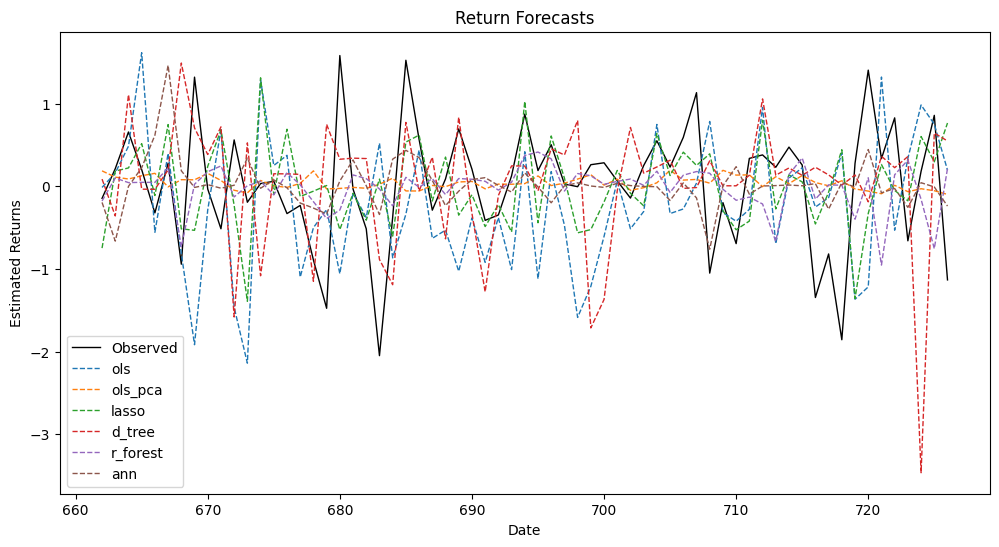

In [11]:
# Define paths for the dataset
fred_path = "https://files.stlouisfed.org/files/htdocs/fred-md/monthly/current.csv"

# Load the data
df, tcodes = load_data(fred_path)

yt = []  # Initialize output variable
N = df.shape[1]  # Number of series kept

for i in range(N):
    dum = transxf(df.iloc[:, i].values, tcodes[i])
    yt.append(dum)

transformed_data = pd.DataFrame(yt).T
transformed_data.columns = df.columns


# Preprocess the data
df = preprocess_data(transformed_data)

# Define initial training window size
initial_window_size = int(len(df)*0.8) 

# Initialize lists to store forecasts and actual values
forecast_results = {
    'ols': [],
    'ols_pca': [],
    'lasso': [],
    'd_tree': [],
    'r_forest': [],
    'ann': [],
    'ann_st_dev': []
}

actual_values = []
test_indices = []


# Loop over the time steps
for t in range(initial_window_size, len(df)-1):

    # Get training data up to time t
    train_data = df.iloc[:t].copy()

    # Get test data at time t+1
    test_data = df.iloc[t:t+1].copy()

    # Check for NaN in train_data or test_data, skip if necessary
    if train_data.isnull().values.any() or test_data.isnull().values.any():
        continue  # Skip this iteration if there are NaN values

    # Scaling
    scaler = StandardScaler()
    train_data_scaled = pd.DataFrame(scaler.fit_transform(train_data), index=train_data.index, columns=train_data.columns)
    test_data_scaled = pd.DataFrame(scaler.transform(test_data), index=test_data.index, columns=test_data.columns)

    # Apply PCA
    pca = PCA(n_components=3, whiten=True, svd_solver='full')
    pca.fit(train_data_scaled.drop("Target", axis=1))

    train_pca = pd.DataFrame(pca.transform(train_data_scaled.drop("Target", axis=1)), index=train_data_scaled.index)
    test_pca = pd.DataFrame(pca.transform(test_data_scaled.drop("Target", axis=1)), index=test_data_scaled.index)

    # Get input dimension for neural network
    input_dim = len(train_data_scaled.columns) - 1  # Exclude the target column

    # Train models
    models, history = train_models(train_data_scaled, train_pca, input_dim)

    # Generate forecasts
    test_forecasts = generate_forecasts(models, test_data_scaled, test_pca)

    # Store forecasts
    for model_name in forecast_results.keys():
        forecast_results[model_name].append(test_forecasts[model_name][0])

    # Store actual value
    actual_values.append(test_data_scaled["Target"].values[0])

    # Store test index
    test_indices.append(test_data.index[0])

# Evaluate models
evaluate_models(forecast_results, actual_values)

# Plot forecasts
plot_forecasts(forecast_results, actual_values, test_indices)